# Algorithm

## Description:
Connected components takes in a binary volume containing clusters and generates labels for those clusters. Specifically, it generates labels such that every voxel within a cluster has the same label as the other voxels within that same clusters, but a different label than all the voxels within all the other clusters. It then turns each of these components into an object of type Cluster.

**Inputs:** 
the input volume 
                         

**Outputs:**
the list of clusters

## Pseudocode
**Overall Structures:**
1. Run Connected Components to label distinct clusters 
2. For each label, find which indices of the matrix are equal to that label and put them in a memberList 
3. Instantiate an object of type Cluster containing the memberList from (2) as its members 

**Pseudocode for Step 1:**
    
       linked = []
       labels = structure with dimensions of data, initialized with the value of Background

       First pass

       for row in data:
           for column in row:
               if data[row][column] is not Background

                   neighbors = connected elements with the current element's value

                   if neighbors is empty
                       linked[NextLabel] = set containing NextLabel
                       labels[row][column] = NextLabel
                       NextLabel += 1

                   else

                       Find the smallest label

                       L = neighbors labels
                       labels[row][column] = min(L)
                       for label in L
                           linked[label] = union(linked[label], L)

       Second pass

       for row in data
           for column in row
               if data[row][column] is not Background
                   labels[row][column] = find(labels[row][column])

       return labels


## Actual Code 

In [63]:
import itertools
import sys
sys.path.insert(0, '../code/functions/')
import connectLib as cLib
import scipy.ndimage as ndimage
import numpy as np
from scipy import sparse

def connectedComponents(volume):
    # the connectivity structure matrix
    s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]
    
    # find connected components
    labeled, nr_objects = ndimage.label(volume, s) 
    #change them to object type Cluster
    if nr_objects == 1: 
        nr_objects += 1
    clusterList = []
    labelTime = 0
    clusterTime = 0
    
    #convert labeled to Sparse
    sparseLabeledIm = np.empty(len(labeled), dtype=object)
    for i in range(len(labeled)):
        sparseLabeledIm[i] = sparse.csr_matrix(labeled[i])
    
    for label in range(0, nr_objects):
        
        memberList = []
        
        start_time = time.time()
        for z in range(len(sparseLabeledIm)):
            memberListWithoutZ = np.argwhere(sparseLabeledIm[z] == label)
            memberListWithZ = [[z] + list(tup) for tup in memberListWithoutZ]
            memberList.extend(memberListWithZ)
        labelTime += time.time() - start_time
        
        start_time = time.time()
        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))
        clusterTime += time.time() - start_time
    print 'Member-Find Time: ' + str(labelTime)
    print 'Cluster Time: ' + str(clusterTime)
    

    return clusterList

**The Cluster Class for Reference:**

In [2]:
import numpy as np
import math

class Cluster:
    def __init__(self, members):
        self.members = members
        self.volume = self.getVolume()

    def getVolume(self):
        return len(self.members)

    def getCentroid(self):
        unzipList = zip(*self.members)
        listZ = unzipList[0]
        listY = unzipList[1]
        listX = unzipList[2]
        return [np.average(listZ), np.average(listY), np.average(listX)]

    def getStdDeviation(self):
        unzipList = zip(*self.members)
        listZ = unzipList[0]
        listY = unzipList[1]
        listX = unzipList[2]
        listOfDistances = []
        for location in self.members:
            listOfDistances.append(math.sqrt((location[0]-self.centroid[0])**2 + (location[1]-self.centroid[1])**2 + (location[2]-self.centroid[2])**2))
        stdDevDistance = np.std(listOfDistances)
        return stdDevDistance

    def probSphere(self):
        unzipList = zip(*self.members)
        listZ = unzipList[0]
        listY = unzipList[1]
        listX = unzipList[2]
        volume = ((max(listZ) - min(listZ) + 1)*(max(listY) - min(listY) + 1)*(max(listX) - min(listX) + 1))
        ratio = len(self.members)*1.0/volume
        return 1 - abs(ratio/(math.pi/6) - 1)

    def getMembers(self):
        return self.members

## Connected Components Conditions
Connected Components would work well under the conditions that the input volume contains seperable, non-overlapping, sparse clusters and that the input volume is in binary-form (i.e. the values of the background voxels are 0's and the value of the foreground voxels are all positive integers). 

Connected Components would work poorly if the volume is not binary (i.e. the values of the background voxels are anything besides 0) or if the clusters are dense or in any way neighboring eachother. 

## Predictable Data Sets

**The Good Data Set:**

**Description:** The good data set is a 1000 x 1000 x 100 volume containing 1875 clusters of size 125 with value of 1. Every other value in the volume is 0. 

**Plot:** I will plot the data at z=5 because it provides better visualization.

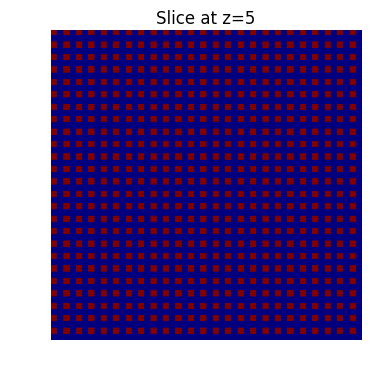

In [7]:
import numpy as np
import matplotlib.pyplot as plt

clusterGrid = np.zeros((100, 1000, 1000))
for i in range(40):
    for j in range(40):
        for k in range(40):
            clusterGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = 1
            
plt.imshow(clusterGrid[5])
plt.axis('off')
plt.title('Slice at z=5')
plt.show()

**Prediction:** I predict that this volume will be perfectly segmented into 1875 clusters.

**The Difficult Data Set:**

**Description:** The good data set is a 1000 x 1000 x 100 volume containing 1875 clusters of size 125 with value of 2. Every other value in the volume is 1. In other words, the image is not binarized.

**Plot:** I will plot the data at z=5 because it provides better visualization.

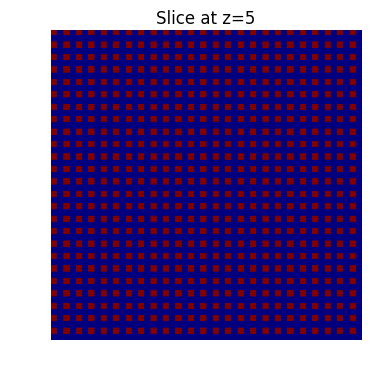

In [75]:
clusterGrid = clusterGrid + 1
plt.imshow(clusterGrid[5])
plt.axis('off')
plt.title('Slice at z=5')
plt.show()

**Prediction:** I predict that the entire volume will be segmented into one big component.

# Simulation
## Toy Data Generation

**The Good Data Set:**

In [5]:
simEasyGrid = np.zeros((100, 100, 100))
for i in range(4):
    for j in range(4):
        for k in range(4):
            simEasyGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = 1

**Predicting what good data will look like:** I believe the good data will look like a grid of 27 cubes, 9 in each slice that contains clusters.

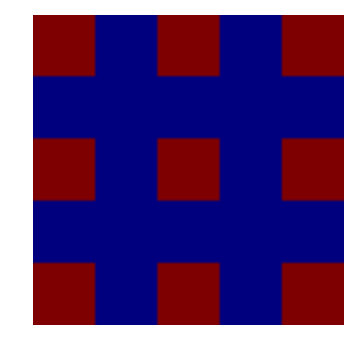

In [8]:
plt.imshow(simEasyGrid[5])
plt.axis('off')
plt.show()

**Visualization relative to prediction:** As predicted, the good data looks like a grid of cubes, 9 in each slice that contains clusters.

**The Difficult Data Set:**

In [9]:
simDiffGrid = simEasyGrid + 1

**Predicting what difficult data will look like:** I believe the good data will look like a grid of 27 cubes, 9 in each slice that contains clusters.

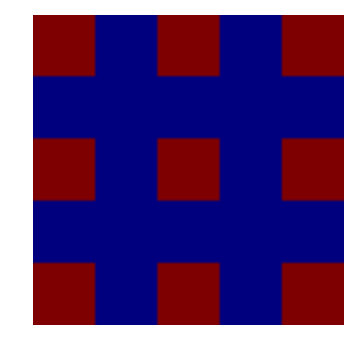

In [10]:
plt.imshow(simDiffGrid[5])
plt.axis('off')
plt.show()

**Visualization relative to prediction:** As predicted, the difficult data looks like a grid of cubes, 9 in each slice that contains clusters.

### Toy Data Analysis
**Good Data Prediction: ** 
I predict that the good data will segment the easy simulation into 27 clusters very quickly.

In [13]:
import time 
def connectAnalysis(rawData, expected):
    start_time = time.time()
    clusterList = connectedComponents(rawData)
    print "time taken to label: " + str((time.time() - start_time)) + " seconds"
    print "Number of connected components:\n\tExpected: " + expected + "\n\tActual: " + str(len(clusterList))
    displayIm = np.zeros_like(rawData)
    for cluster in range(len(clusterList)):
        for member in range(len(clusterList[cluster].members)):
            z, y, x = clusterList[cluster].members[member]
            displayIm[z][y][x] = cluster

    plt.imshow(displayIm[0])
    plt.axis('off')
    plt.show()

Member-Find Time: 2.84432816505
Cluster Time: 0.000165700912476
time taken to label: 2.91217899323 seconds
Number of connected components:
	Expected: 27
	Actual: 27


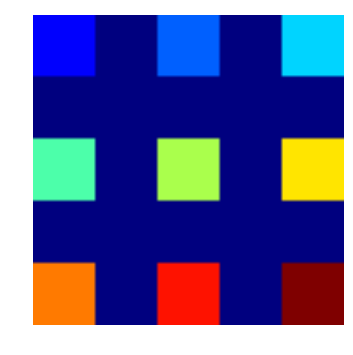

In [65]:
connectAnalysis(simEasyGrid, '27')

**Results of Good Data Relative to Predictions:** As expected, the volume was segmented into 27 seperate clusters very quickly.

**Repeating the Good Data Simulation:**

Member-Find Time: 3.17544007301
Cluster Time: 0.00019907951355
Member-Find Time: 2.29291534424
Cluster Time: 0.000168561935425
Member-Find Time: 2.79093766212
Cluster Time: 0.000163793563843
Member-Find Time: 2.07920646667
Cluster Time: 0.000167846679688
Member-Find Time: 2.74887037277
Cluster Time: 0.000162124633789
Member-Find Time: 2.10273694992
Cluster Time: 0.000173330307007
Member-Find Time: 2.70303726196
Cluster Time: 0.000163555145264
Member-Find Time: 2.22112131119
Cluster Time: 0.000166654586792
Member-Find Time: 2.70940518379
Cluster Time: 0.000164270401001
Member-Find Time: 2.77786159515
Cluster Time: 0.000160217285156


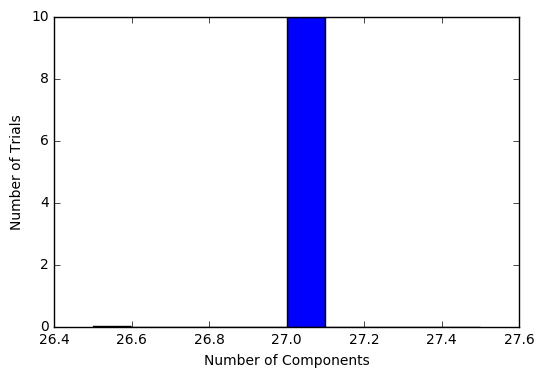

Average Number of Components on Easy Simulation Data:
	Expected: 27	Actual: 27.0


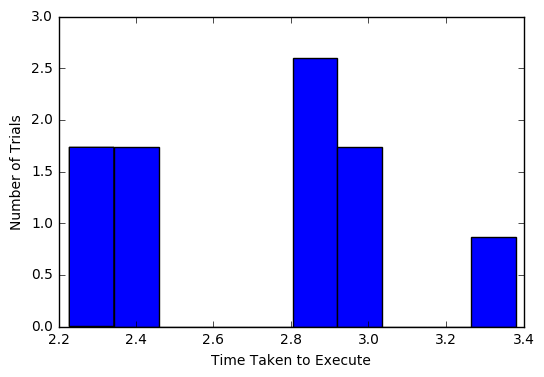

Average Time Taken to Execute: 2.71594874859


In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
labeledLengths = []
times = []

for i in range(10):
    start_time = time.time()
    clusterList = connectedComponents(simEasyGrid)
    labeledLengths.append(len(clusterList))
    times.append((time.time() - start_time))
    

pylab.hist(labeledLengths, normed=1)
pylab.xlabel('Number of Components')
pylab.ylabel('Number of Trials')
pylab.show()
print 'Average Number of Components on Easy Simulation Data:\n\tExpected: 27\tActual: ' + str(np.mean(labeledLengths))


pylab.hist(times, normed=1)
pylab.xlabel('Time Taken to Execute')
pylab.ylabel('Number of Trials')
plt.show()
print 'Average Time Taken to Execute: ' + str(np.mean(times))

**Difficult Data Prediction:** I predict the difficult data will be segmented into 1 big cluster.

Member-Find Time: 2.08157920837
Cluster Time: 2.59876251221e-05
time taken to label: 2.18045091629 seconds
Number of connected components:
	Expected: 1
	Actual: 1


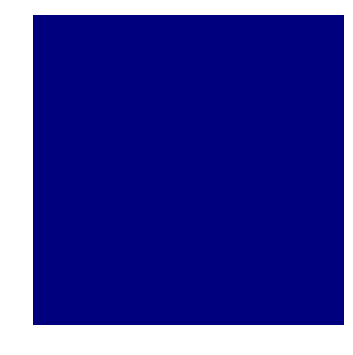

In [67]:
connectAnalysis(simDiffGrid, '1')

**Results of Difficult Data Result Relative to Prediction:** As expected, the volume was segmented into one big component.

**Repeating the Difficult Data Simulation:**

Member-Find Time: 2.51047825813
Cluster Time: 1.00135803223e-05
Member-Find Time: 1.83860087395
Cluster Time: 1.09672546387e-05
Member-Find Time: 2.45955181122
Cluster Time: 1.00135803223e-05
Member-Find Time: 1.77215600014
Cluster Time: 1.00135803223e-05
Member-Find Time: 2.64275789261
Cluster Time: 9.77516174316e-06
Member-Find Time: 2.64882493019
Cluster Time: 3.19480895996e-05
Member-Find Time: 3.60122489929
Cluster Time: 1.50203704834e-05
Member-Find Time: 2.59811091423
Cluster Time: 8.82148742676e-06
Member-Find Time: 1.77408075333
Cluster Time: 1.50203704834e-05
Member-Find Time: 2.45674586296
Cluster Time: 1.09672546387e-05


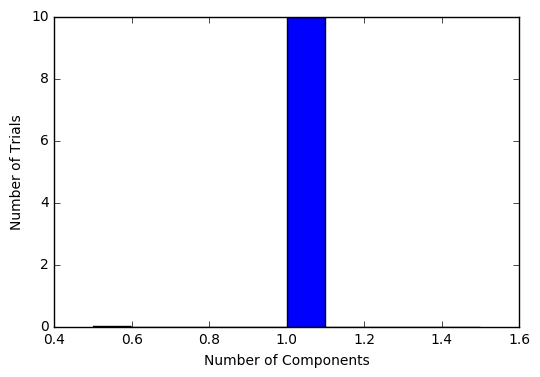

Average Number of Components on Difficult Simulation Data:
	Expected: 27	Actual: 1.0


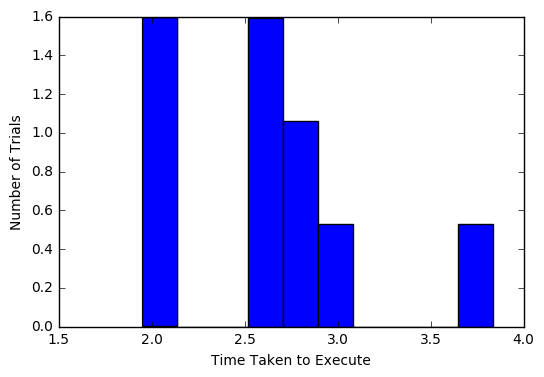

Average Time Taken to Execute: 2.62728247643


In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
labeledLengths = []
times = []

for i in range(10):
    start_time = time.time()
    clusterList = connectedComponents(simDiffGrid)
    labeledLengths.append(len(clusterList))
    times.append((time.time() - start_time))
    

pylab.hist(labeledLengths, normed=1)
pylab.xlabel('Number of Components')
pylab.ylabel('Number of Trials')
pylab.show()
print 'Average Number of Components on Difficult Simulation Data:\n\tExpected: 27\tActual: ' + str(np.mean(labeledLengths))


pylab.hist(times, normed=1)
pylab.xlabel('Time Taken to Execute')
pylab.ylabel('Number of Trials')
plt.show()
print 'Average Time Taken to Execute: ' + str(np.mean(times))

**Summary of Performances:** Connected Components performed extremely well on the easy simulation, correctly detecting 27 components very quickly for every trial. It also performed poorly as expected on the difficult simulation, connecting 1 component for every trial

# Real Data
## Synthetic Data Analysis
**Description:** Validation testing will be performed on a a 100x100x100 volume with a pixel intensity distribution approximately the same as that of the true image volumes (i.e., 98% background, 2% synapse). The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~1 micron ^3, or about 139 voxels (assuming the synthetic data here and the real world data have identical resolutions). After the data goes through the algorithm, I will gauge performance based on the following:
number of clusters (should be about 500)
volumetric density of data (should be about 2% of the data)

**Plotting Raw Synthetic Data:**

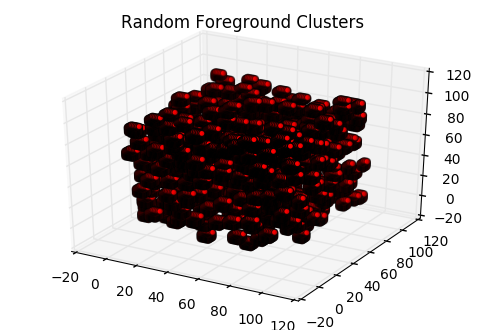

In [55]:
from random import randrange as rand
from mpl_toolkits.mplot3d import axes3d, Axes3D 

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 5):
        for y in range(-1, 5):
            for x in range(-1, 5):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume

foreground = generateTestVolume()


#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground Clusters')
plt.show()

**Expectation for Synthetic Data:** I expect that the Connected Components will detect around 500 clusters.

**Running Algorithm on Synethetic Data:**

Analysis After Adjusting Clustering Instantiation
Member-Find Time: 1.89112901688
Cluster Time: 0.00317358970642
time taken to label: 1.91724491119 seconds
Number of connected components:
	Expected: Around 500
	Actual: 494


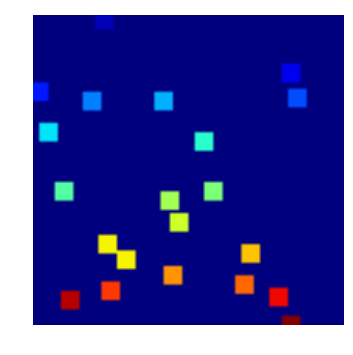

In [402]:
print 'Analysis After Adjusting Clustering Instantiation'
connectAnalysis(foreground, "Around 500")

Analysis With Sparse Arrays
Member-Find Time: 7.46229243279
Cluster Time: 0.0021870136261
time taken to label: 7.52881002426 seconds
Number of connected components:
	Expected: Around 500
	Actual: 423


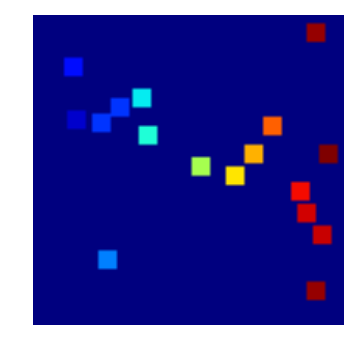

In [57]:
print 'Analysis With Sparse Arrays'
connectAnalysis(foreground, "Around 500")

**Results on Synthetic Data Relative to Prediction:** The data correctly detected around 500 connected components. More importantly, it did so extremely quickly.

## Real Data Analysis
**Visualizing Real Data Subset:**

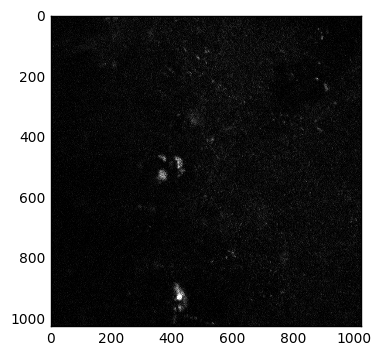

In [58]:
import sys
sys.path.insert(0,'../code/functions/')
import tiffIO as tIO
import connectLib as cLib
import plosLib as pLib

dataSubset = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp1.tif'))[0][0:5]
plt.imshow(dataSubset[0], cmap="gray")
plt.show()

**Predicting Performance of Subset:** I predict that the data will be segmented into roughly 2000 synapses, hopefully in under a minute.

**Running the Algorithm on Real Data Subset:**

In [59]:
#finding the clusters after plosPipeline
plosOutSub = pLib.pipeline(dataSubset)

In [60]:
#binarize output of plos lib
bianOutSub = cLib.otsuVox(plosOutSub)

In [61]:
#dilate the output based on neigborhood size
bianOutSub = ndimage.morphology.binary_dilation(bianOutSub).astype(int)

Analysis After Adjusting Cluster class
Member-Find Time: 36.6950345039
Cluster Time: 0.0178139209747
time taken to label: 36.7878818512 seconds
Number of connected components:
	Expected: Around 2 thousand
	Actual: 1833


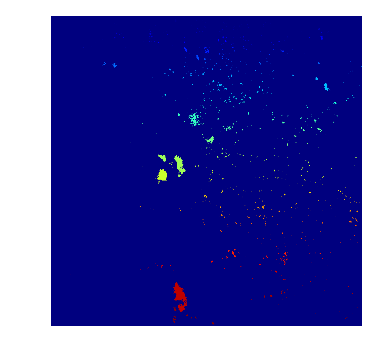

In [415]:
print 'Analysis After Adjusting Cluster class'
connectAnalysis(bianOutSub, 'Around 2 thousand')

Analysis Using Sparse Arrays
Member-Find Time: 14.0138905048
Cluster Time: 0.005779504776
time taken to label: 14.2096440792 seconds
Number of connected components:
	Expected: Around 2 thousand
	Actual: 1833


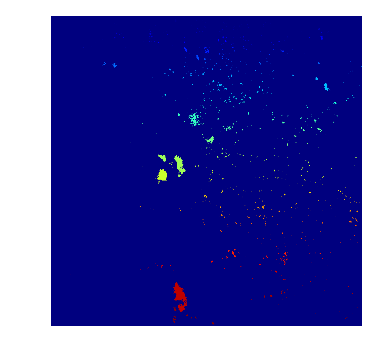

In [64]:
print 'Analysis Using Sparse Arrays'
connectAnalysis(bianOutSub, 'Around 2 thousand')

## Whole Data Set

In [69]:
import pickle
wholeDat = pickle.load(open('bianOutSubDil.image', 'rb'))

**Performance of Subset Relative to Predictions:** As expected, Connected Components picked up around 2 thousand cluster in under a minute. Furthermore, my changes to the Cluster class cut the total time to 36 seconds down from 87 by reducing the Cluster Time from 51 seconds to .018 seconds.

**Expectations in Relation to Other Data Sets:** I expect that this version of Connected Components will work well for all data sets that are binary (that is, 0's for background, any positive integer for foreground). It also seems that the algorithm performs particularly quickly for data sets with fewer labels. 

**Ways to Improve:** To expand to larger data sets, we would need to find an efficient way to search through a matrix for specific values with the knowledge that same-valued-indices will all be near eachother in clusters.